## Final report outline, and quick notes

- In Monte carlo simulation you are really looking to reduce the standard error of your approximation.
  - This is why the Predicted price is meaningless, however the **standard error** is **very important**
- A main Drawback of the balck-scholes model is that it assumes a **constant volatility**
  - Discuss the assumptions of the BS model and how they help or hurt it. 
    - Stock follows a lognormal distribution
    - stock prices can not be negative 
    - no dividends are paid 
    - frictionless market 
    - constant volatility
- Get data from a few different Contracts, to compare the results.  
  - Lets try Short term, Mid term, and Long term contracts. Mind you this gives you a chance to excercise the option each day. 
    - Short term: 60 days 
    - Medium term: 180 days 
    - Long Term: 360 days

**Main Idea:** 
1. Why are we pricing options? 
   1. We want to find the fair value of the option today
   2. This will help us determine if an option is overpriced or not. 
2. Compare simulated, numerical, and predicted results to the observed prices.
   1. Observed prices are set by the market maker, so we can also evaluate how much the market maker is charging for the option.
3. Compare the standard error of the predicted prices to the standard error of the observed prices.
 
----

Outline for the final presentation (from the paper referenced below)
1. Present a simple numerical example of the simulation apprach 
2. Describe the undderlying theoretical framework 
3. Provide specific erxamples of the application of this approach 
4. discuss number of numerical and implementation issues
5. summarize and give concluding remarks.


**Notes From The paper:**
- On the exercise date, the optimal exercise strategy for an American Option is to do so if the option is in the money. Prior to the exercise date, the optimal strategy is to compare the immediate exercise value with the expected cashflows from continuing to the option until the exercise date. If the immediate value is greater than the expected value at expiration, we exercise the option. Else we continue to the expiration date.
- The holder of an American option optimally compares the payoff from the immediate exercise with the expected payoff from continutation, and then chooses to exercise if the immediate payoff is higher. 
  - The key to optimaly exercise an american option is identifying the conditional expected value of the option at the exercise date.
    - The optimal exercise stategy is fundamentally determined by the conditional expectation of the payoff from continuing to keep the option alive. 
- A key insight from the Longstaff-Schwartz paper is that this conditional expectation can be estimated from the cross-sectional information in the simulation by using the least squares method. 
    -  More specifically Longstaff and Schwartz show that:
       -  The ex post realized payoffs from continuation on functions of the values of the state variables on functions of the values of the state variables. 
       -  The fitted value from this regression provides a direct estimate of the conditional expectation function
       -  By estimating the conditional expectation function for each exercise date, we obtain a complete specification of the optimal exercise strategy for the option, along each of the simulated paths. 
-  Another key insight is that the paper only only includes the paths for which the **option is in the money**. 

**Source:** *"Valuing American Options by Simulation: A Simple Least-Squares Approach, Francis A. Longstaff, and Eduardo S. Schwartz UCLA "*

----

In [33]:
import re
import datetime as dt 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from IPython.display import display
from tqdm import tqdm
import sqlite3 as sql 
from scipy.optimize import minimize
import scipy.stats as st 
%matplotlib inline

db_path = '../data/options-data.db'
conn = sql.connect(db_path)
c = conn.cursor()
# Get stocks (table names in db)
stocks = [x[0] for x in c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()]
# Create dict of dataframes
lod = {}
for stock in stocks:
    lod[stock] = pd.read_sql(f'select * from {stock}', conn, parse_dates = ['gatherdate', 'expiry'])

df = lod['spy'].copy()
df['days_to_expiry'] = (df['expiry'] - df['gatherdate']).dt.days
# #contracts = df.drop(columns = ['expiry', 'strike', 'type']).set_index(['contractsymbol', 'gatherdate']).sort_index().copy()
contracts = df.set_index(['contractsymbol', 'gatherdate']).sort_index().copy()
contracts = contracts[contracts.inthemoney == '1'].copy()
# # keep contracts that have atleast 10 entries 
contracts = contracts.groupby('contractsymbol').filter(lambda x: len(x) > 50)

# get close to the money strikes, based on the mean. 
ad = contracts.stk_price.tail(20).drop_duplicates().describe()
adr = ad['mean'] - 2*ad['std'], ad['mean'] + 2*ad['std']
contracts = contracts[contracts.strike.between(*adr)]
contracts.shape


(5354, 11)

How to take in account Early Excersise?

1. Simulate the underlying asset price paths using a stochastic process such as geometric Brownian motion.
2. At each time step, determine the optimal exercise decision for each path by comparing the immideate value of the option to the value if you were to  con to hold the option.
3. Use regression techniques to estimate the continuation value of the option as a function of the simulated asset prices, exercise decisions, and other relevant variables.
4. Backward-induct to the beginning of the option's life to obtain the option's fair value.
5. Repeat the simulation and valuation process many times to obtain a more accurate estimate of the option's fair value.

---- 
# American Test 

The input parameters for this function are:
- `maturity`: the time to maturity of the option (in years)
- `strike_price`: the strike price of the option
- `spot_price`: the current spot price of the underlying asset
- `volatility`: the volatility of the underlying asset's returns
- `risk_free_rate`: the risk-free interest rate
- `num_sims`: the number of Monte Carlo simulations to run
- `num_time_steps`: the number of time steps to use in the simulation
- `option_type`: the type of option, either "call" or "put"

The function returns the estimated price of the option.

In [34]:
# MY LSMC CODE 
def gaussian_basis(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi)) # Gaussian Basis Function

def design_matrix(x, deg, func = gaussian_basis):
    # create design matrix with basis functions
    X = np.zeros((len(x), deg))
    for i in range(deg):
        mu = np.linspace(min(x), max(x), deg)[i]
        sigma = (max(x) - min(x)) / (deg * 2)
        X[:, i] = func(x, mu, sigma)
    return X

def longstaff_schwartz0(deg = 3):
        # set up time grid
        t = np.linspace(0, T, days+1)
        # given no prior exercise, the value of the option is the payoff at maturity
        if option_type == 'call':
            cashflow = np.maximum(S[-1,:]-K, 0.0)
        elif option_type == 'put':
            cashflow = np.maximum(K - S[-1,:], 0.0)
        # iterate backwards to get conditional payoffs
        for i in range(days-1, 0, -1):
            # get discount factor between time t and t+1
            df = np.exp(-r * (t[i+1] - t[i]))
            # discount the cashflows found at time t+1
            cashflow = df * cashflow
            x = S[i, :]
            # get the exercise value for time t[i]
            if option_type == 'call':
                exercise = np.maximum(x - K, 0.0)
            elif option_type == 'put':
                exercise = np.maximum(K - x, 0.0)
            # get ITM paths 
            itm = exercise > 0
            # fit gaussian basis functions to the cashflows
            xvars = design_matrix(x[itm], deg)
            coef = np.linalg.lstsq(xvars, cashflow[itm], rcond = None)[0]
            fitted = lambda x: np.dot(design_matrix(x, deg), coef)
            # get continuation value
            cont = fitted(x)
            # find were exercise is beneficial 
            ex_idx = itm & (exercise > cont)
            # update cashflows
            cashflow[ex_idx] = exercise[ex_idx]
        return cashflow.mean(axis = 0) * np.exp(-r * (t[1]- t[0]))

In [35]:
# Longstaff-Schwartz Monte Carlo American Option Pricing
import numpy as np
from numpy.polynomial import Polynomial

# X: matrix of simulated paths
# t: vector of time steps
# df: discount factor function
# fit: function to fit continuation value
# exercise_payoff: function to compute exercise payoff
# itm_select: function to select in-the-money paths

def longstaff_schwartz_iter(X, t, df, fit, exercise_payoff, itm_select=None):
    # given no prior exercise we just receive the final payoff
    cashflow = exercise_payoff(X[-1, :])
    # iterating backwards in time
    for i in reversed(range(1, X.shape[0] - 1)):
        # discount cashflows from next period
        cashflow = cashflow * df(t[i], t[i + 1])
        # stock price at time t[i]
        x = X[i, :]
        # exercise value for time t[i]
        exercise = exercise_payoff(x)
        # boolean index of all in-the-money paths
        # (paths considered for exercise)
        itm = itm_select(exercise, x) if itm_select else np.full(x.shape, True)
        # fit curve
        fitted = fit(x[itm], cashflow[itm])
        # approximate continuation value
        continuation = fitted(x)
        # boolean index where exercise is beneficial
        ex_idx = itm & (exercise > continuation)
        # update cashflows with early exercises
        cashflow[ex_idx] = exercise[ex_idx]

        yield cashflow, x, fitted, continuation, exercise, ex_idx
        
def longstaff_schwartz(X, t, df, fit, exercise_payoff, itm_select=None):
    # iterate over time steps
    for cashflow, *_ in longstaff_schwartz_iter(
        X, t, df, fit, exercise_payoff, itm_select
    ):
        pass
    # return discounted average of cashflows
    return cashflow.mean(axis=0) * df(t[0], t[1])

def ls_american_option_quadratic_iter(X, t, r, strike):
    # given no prior exercise we just receive the payoff of a European option
    cashflow = np.maximum(strike - X[-1, :], 0.0)
    # iterating backwards in time
    for i in reversed(range(1, X.shape[0] - 1)):
        # discount factor between t[i] and t[i+1]
        df = np.exp(-r * (t[i + 1] - t[i]))
        # discount cashflows from next period
        cashflow = cashflow * df
        x = X[i, :]
        # exercise value for time t[i]
        exercise = np.maximum(strike - x, 0.0)
        # boolean index of all in-the-money paths
        itm = exercise > 0
        # fit polynomial of degree 2
        fitted = Polynomial.fit(x[itm], cashflow[itm], 2)
        # approximate continuation value
        continuation = fitted(x)
        # boolean index where exercise is beneficial
        ex_idx = itm & (exercise > continuation)
        # update cashflows with early exercises
        cashflow[ex_idx] = exercise[ex_idx]

        yield cashflow, x, fitted, continuation, exercise, ex_idx

def longstaff_schwartz_american_option_quadratic(X, t, r, strike):
    for cashflow, *_ in ls_american_option_quadratic_iter(X, t, r, strike):
        pass
    # return discounted average of cashflows
    return cashflow.mean(axis=0) * np.exp(-r * (t[1] - t[0]))

In [36]:
# Monte Carlo Simulation of the stock price paths to find Fair Value of the option
def mc_sim(S0, r, sigma, K, T, N, days, otype):
    
    Z = np.random.normal(size=N) # Standard Normal of size N, for error term
    ST = S0*np.exp((r-0.5*sigma**2)*T+sigma*np.sqrt(T)*Z) # lognormal distribution of the price
    
    # Monte Carlo simulation of the stock price paths
    dt = T/days  
    S = np.zeros((days+1, N))  
    S[0] = S0  
    for t in range(1, days+1):
        Z = np.random.normal(size=N)
        S[t] = S[t-1]*np.exp((r-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*Z) # Geometric Brownian Motion

    # calculate the payoff at maturity
    if otype.lower() == 'call':
        hT = np.maximum(S[-1]-K, 0)
    elif otype.lower() == 'put':
        hT = np.maximum(K-S[-1], 0)

    # calculate the Monte Carlo estimator
    C0 = np.exp(-r*T)*np.sum(hT)/N
    return C0


In [37]:
otype = 'call' # option type

S0 = 100
K = 105
r = 0.03454
sigma = .12
days = 100
T = days / 252
Observed = 5.00

# Step 1: Obtain Simulated stock price data, via geometric brownian motion
N = 1000 # 2 million sims

dt = T/days  
S = np.zeros((days+1, N))  
S[0] = S0  
for t in range(1, days+1):
    Z = np.random.normal(size=N)
    S[t] = S[t-1]*np.exp((r-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*Z) # Geometric Brownian Motion

# Run LSMC, to obtain fair option price at time 0 
t = np.linspace(0, dt, days+1)
lsm_fair_price = longstaff_schwartz_american_option_quadratic(S, t, r, K)
optimal_excercise_points = np.where(Observed > lsm_fair_price)

# Monte Carlo Simulation at expiration 
mc_fair_price = mc_sim(S0, r, sigma, K, T, N, days, otype)

# Black Scholes Comparison 
from scipy.stats import norm
d1 = (np.log(S0/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
d2 = (np.log(S0/K)+(r-0.5*sigma**2)*T)/(sigma*np.sqrt(T))
bs_call =  (S0*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2))
if otype.lower() == 'put':
    bs_call = bs_call - S0 + K*np.exp(-r*T)


print(f'''
Option Type: {otype.capitalize()}
Stock Price Today: ${S0:.2f}
Strike Price: ${K:.2f}
Days to Expiration: {days}
Volatility: {sigma:.4f}

LSM Fair Value Today: \x1b[31m{lsm_fair_price:.4f}\x1b[0m
Monte Carlo Fair Value Today: \033[94m{mc_fair_price:.4f}\033[0m
Black Scholes Fair Value Today: \033[92m{bs_call:.4f}\033[0m
Observed Price Today: {Observed:.4f}
Simulated Possible Excercise points after today: {optimal_excercise_points[0].shape[0]}

''')


Option Type: Call
Stock Price Today: $100.00
Strike Price: $105.00
Days to Expiration: 100
Volatility: 0.1200

LSM Fair Value Today: 5.5960
Monte Carlo Fair Value Today: 1.6430
Black Scholes Fair Value Today: 1.6080
Observed Price Today: 5.0000
Simulated Possible Excercise points after today: 0




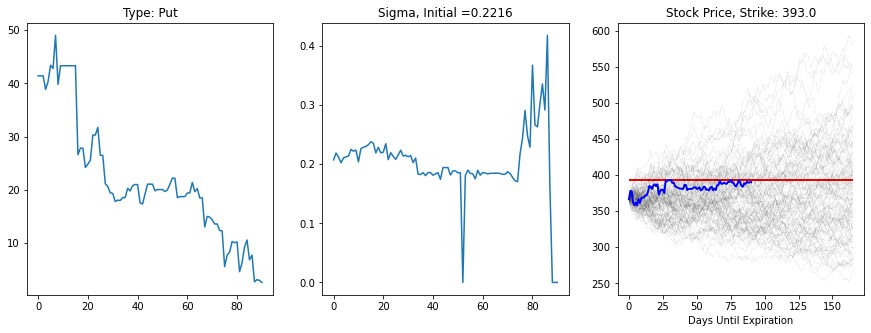


Option Type: Put
Volatility: 0.2074

Stock Price Today: $366.61
Strike Price: $393.00

LSM Fair Value Today: 42.2655
Black Scholes Fair Value Today: 33.8921
Monte Carlo Fair Value Today: 34.9876
Observed Price Today: 41.4000
Simulated Possible Excercise points after today: 10




In [38]:
## Choose Random Contract 
c = contracts.index.get_level_values(0)
# choose a random contract
contract = c[np.random.randint(0, len(c))]
# get the data for that contract
contract_data = contracts.loc[contract].copy()
contract_data = contract_data.groupby(contract_data.index).last()

cd = contract_data['2022-10-01':].copy()
cd = cd.groupby(cd.index).first().reset_index()
Observed = cd['lastprice'].to_numpy() # Observed Option Prices 
rsp = cd['stk_price'].to_numpy() # real stock price data
otype = cd.type.iloc[0] # option type

S0 = rsp[0]
K = cd.strike.iloc[0]
r = 0.0407
sigma = cd.impliedvolatility.iloc[0]
T = cd.days_to_expiry.iloc[0]/252

# Step 1: Obtain Simulated stock price data, via geometric brownian motion
N = 100
days = cd.days_to_expiry.iloc[0]
dt = T/days  
S = np.zeros((days+1, N))  
S[0] = S0  
for t in range(1, days+1):
    Z = np.random.normal(size=N)
    S[t] = S[t-1]*np.exp((r-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*Z) # Geometric Brownian Motion

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
cd['lastprice'].plot(ax = ax[0])
cd['impliedvolatility'].plot(ax = ax[1])
ax[2].plot(S, color = 'k', alpha = 0.1, lw = .5)
ax[2].hlines(cd.strike.iloc[0], 0, days, color = 'r', lw = 2)
ax[2].plot(rsp[-days:], color = 'b', alpha = 1, lw = 2)

ax[0].set_title(f'Type: {contract_data.type.iloc[0]}')
ax[1].set_title(f'Sigma, Initial ={contract_data.impliedvolatility.iloc[0]:.4f}')
ax[2].set_title(f'Stock Price, Strike: {contract_data.strike.iloc[0]}')
ax[2].set_xlabel('Days Until Expiration')

plt.show()


# Run LSMC, to obtain fair option price at time 0 
t = np.linspace(0, T, days+1)
lsm_fair_price = longstaff_schwartz_american_option_quadratic(S, t, r, K)
optimal_excercise_points = np.where(Observed > lsm_fair_price)

# Monte Carlo Simulation at expiration 
mc_fair_price = mc_sim(S0, r, sigma, K, T, N, days, otype)


# Black Scholes Comparison 
# calculate the analytical European call option price
from scipy.stats import norm
d1 = (np.log(S0/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
d2 = (np.log(S0/K)+(r-0.5*sigma**2)*T)/(sigma*np.sqrt(T))
bs_call =  (S0*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2))
if otype.lower() == 'put':
    bs_call = bs_call - S0 + K*np.exp(-r*T)


print(f'''
Option Type: {otype}
Volatility: {sigma:.4f}

Stock Price Today: ${S0:.2f}
Strike Price: ${K:.2f}

LSM Fair Value Today: \x1b[31m{lsm_fair_price:.4f}\x1b[0m
Black Scholes Fair Value Today: \033[92m{bs_call:.4f}\033[0m
Monte Carlo Fair Value Today: \033[94m{mc_fair_price:.4f}\033[0m
Observed Price Today: {Observed[0]:.4f}
Simulated Possible Excercise points after today: {optimal_excercise_points[0].shape[0]}

''')


Option Type: Call
Volatility: 0.2594

Stock Price Today: $393.06
Strike Price: $389.00

LSM Fair Value Today: 30.9269
Black Scholes Fair Value Today: 48.5651
Monte Carlo Fair Value Today: 49.8785
Observed Price Today: 37.9900
Simulated Possible Excercise points after today: 37




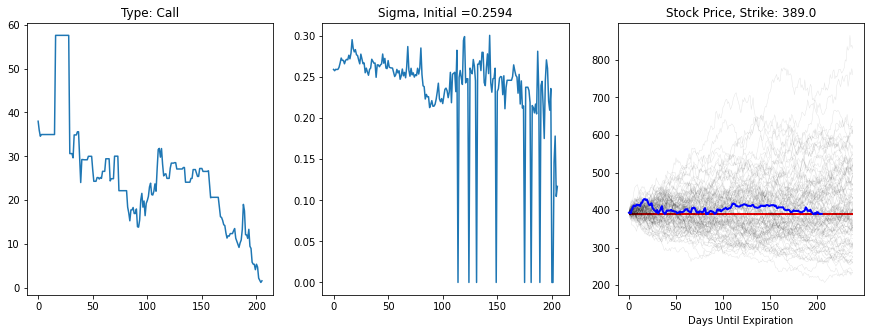

In [39]:
## Choose Random Contract 
c = contracts.index.get_level_values(0)
# choose a random contract
contract = c[np.random.randint(0, len(c))]
# get the data for that contract
contract_data = contracts.loc[contract].copy()
contract_data = contract_data.groupby(contract_data.index).last()

cd = contract_data['2022-01-01':].copy()
cd = cd.groupby(cd.index).first().reset_index()
Observed = cd['lastprice'].to_numpy() # Observed Option Prices 
rsp = cd['stk_price'].to_numpy() # real stock price data
otype = cd.type.iloc[0] # option type

S0 = rsp[0]
K = cd.strike.iloc[0]
r = 0.0407
sigma = cd.impliedvolatility.iloc[0]
T = cd.days_to_expiry.iloc[0]/252

# Step 1: Obtain Simulated stock price data, via geometric brownian motion
N = 100
days = cd.days_to_expiry.iloc[0]
dt = T/days  
S = np.zeros((days+1, N))  
S[0] = S0  
for t in range(1, days+1):
    Z = np.random.normal(size=N)
    S[t] = S[t-1]*np.exp((r-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*Z) # Geometric Brownian Motion

# Run LSMC, to obtain fair option price at time 0 
t = np.linspace(0, T, days+1)
lsm_fair_price = longstaff_schwartz_american_option_quadratic(S, t, r, K)
optimal_excercise_points = np.where(Observed > lsm_fair_price)

# Monte Carlo Simulation at expiration 
mc_fair_price = mc_sim(S0, r, sigma, K, T, N, days, otype)

# Black Scholes Comparison 
from scipy.stats import norm
d1 = (np.log(S0/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
d2 = (np.log(S0/K)+(r-0.5*sigma**2)*T)/(sigma*np.sqrt(T))
bs_call =  (S0*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2))
if otype.lower() == 'put':
    bs_call = bs_call - S0 + K*np.exp(-r*T)


print(f'''
Option Type: {otype}
Volatility: {sigma:.4f}

Stock Price Today: ${S0:.2f}
Strike Price: ${K:.2f}

LSM Fair Value Today: \x1b[31m{lsm_fair_price:.4f}\x1b[0m
Black Scholes Fair Value Today: \033[92m{bs_call:.4f}\033[0m
Monte Carlo Fair Value Today: \033[94m{mc_fair_price:.4f}\033[0m
Observed Price Today: {Observed[0]:.4f}
Simulated Possible Excercise points after today: {optimal_excercise_points[0].shape[0]}

''')
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
cd['lastprice'].plot(ax = ax[0])
cd['impliedvolatility'].plot(ax = ax[1])
ax[2].plot(S, color = 'k', alpha = 0.1, lw = .5)
ax[2].hlines(cd.strike.iloc[0], 0, days, color = 'r', lw = 2)
ax[2].plot(rsp[-days:], color = 'b', alpha = 1, lw = 2)

ax[0].set_title(f'Type: {contract_data.type.iloc[0]}')
ax[1].set_title(f'Sigma, Initial ={contract_data.impliedvolatility.iloc[0]:.4f}')
ax[2].set_title(f'Stock Price, Strike: {contract_data.strike.iloc[0]}')
ax[2].set_xlabel('Days Until Expiration')

plt.show()


In [49]:
# SET PARAMETERS & Test Simulations
option_type = 'call' # option type
S0 = 100
K = 105
r = 0.01
sigma = .14
days = 100
Observed = 5.00
N = 100000000 # 1 million sims

sel_excercise = lambda exercise, x: exercise > 0
df = lambda t0, t1: np.exp(-r * (t1 - t0)) # discount factor function 
t = np.linspace(0, 1, len(S))

def gaussian_basis_fit(x, y):
    # fit gaussian basis functions to cashflows
    xvars = design_matrix(x, deg = 3)
    coef = np.linalg.lstsq(xvars, y, rcond=None)[0]
    return lambda x: np.dot(design_matrix(x, deg = 3), coef)
def payoff(x):
    if option_type == 'call':
        return np.maximum(x - K, 0.0)
    elif option_type == 'put':
        return np.maximum(K - x, 0.0)

MYLMSC = longstaff_schwartz0(deg = 3)
OG_LMSC = longstaff_schwartz(S, t, df, gaussian_basis_fit, payoff, sel_excercise)

print(f"""
MY LMSC: {MYLMSC}
OG LMSC: {OG_LMSC}
""")


MY LMSC: 290.1477654026039
OG LMSC: 290.1770195605532

